# Imports

In [42]:
import cv2
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from PIL import Image

# Directories

In [44]:
main_kkanji_dir = "/home/beav3r/Bachelor_work/Bachelor_work/data/kkanji/kkanji2"
generative_kkanji_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji2_with_gen"
kkanji_for_GAN_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN"
kkanji_for_VAE_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_for_VAE"

# Global variables

In [47]:
int_inf = 9223372036854775807

num_classes_GAN = 0
for i in os.listdir(kkanji_for_GAN_dir):
    num_classes_GAN += 1
num_classes_GAN

num_classes_VAE = 0

2997

# Helping functions

In [ ]:
# Define the loss function for VAE
def loss_function_VAE(reconstructed_img, original_img, mu, logvar):
    # Reconstruction loss (using MSE or BCE)
    recon_loss = F.mse_loss(reconstructed_img, original_img, reduction='sum')

    # KL Divergence: regularizing the latent space
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: reconstruction + KL divergence
    return recon_loss + kl_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..1.0].


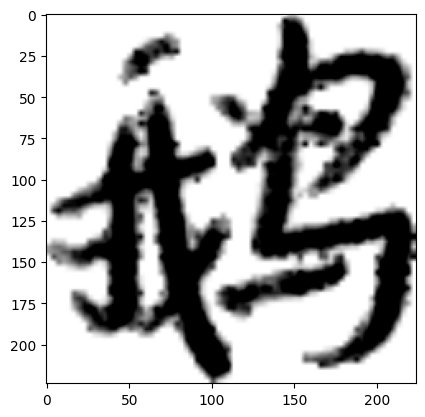

In [21]:
# Image preprocessing for resnet 18

# Preprocessing: Resize to 224x224 and stack the grayscale image into 3 channels
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Load and preprocess image
image = Image.open('/home/beav3r/Bachelor_work/Bachelor_work/data/CASIA Online and Offline Chinese Handwriting Databases/My_processed_Gnt1.0Train/鹅/0.png')  # Open image 


# Save original image
image.save('/mnt/d/Bachelor_work/data_for_model/test.png')

# Show original image
plt.imshow(image, cmap='gray')  # Show image
plt.show()

image_tensor_without_batch = preprocess(image)  # Preprocess image

# Add batch dimension
image_tensor = image_tensor_without_batch.unsqueeze(0)  # Add batch size

# Show image
plt.imshow(image_tensor[0].permute(1, 2, 0).numpy())  # Show image



In [23]:
kkanji_images_classes_by_amount = defaultdict(list)
kkanji_images_classes_by_amount['1-14'] = []
kkanji_images_classes_by_amount['15-29'] = []
kkanji_images_classes_by_amount['30-99'] = []
kkanji_images_classes_by_amount['100-299'] = []
kkanji_images_classes_by_amount['300+'] = []

# Function to classify the value into the appropriate category
def classify_value(value):
    if 1 <= value <= 14:
        return '1-14'
    elif 15 <= value <= 29:
        return '15-29'
    elif 30 <= value <= 99:
        return '30-99'
    elif 100 <= value <= 299:
        return '100-299'
    else:
        return '300+'

# Read and process the file
with open('/home/beav3r/Bachelor_work/Bachelor_work/kkanji_classes_distribution_sorted.txt', 'r') as file:
    for line in file:
        # Split the line into Unicode character and value
        unicode_char, value_str = line.strip().split()
        value = int(value_str)
        
        # Classify the value and add to the appropriate category
        category = classify_value(value)
        kkanji_images_classes_by_amount[category].append(unicode_char)

# Print the dictionary to verify the result
for category, unicode_chars in kkanji_images_classes_by_amount.items():
    print(f"{category}: {unicode_chars} ({len(unicode_chars)})")

1-14: ['U+9808', 'U+6182', 'U+7169', 'U+7981', 'U+770B', 'U+5E97', 'U+98FD', 'U+8B02', 'U+56FA', 'U+5805', 'U+52FA', 'U+72D0', 'U+79AE', 'U+99C4', 'U+9591', 'U+6176', 'U+7C9F', 'U+7B39', 'U+9298', 'U+6271', 'U+57F7', 'U+65E7', 'U+697C', 'U+5DF2', 'U+8AFA', 'U+8A2D', 'U+5BE6', 'U+671F', 'U+6804', 'U+76DC', 'U+5951', 'U+8B49', 'U+5B78', 'U+6939', 'U+67AF', 'U+8CAF', 'U+53F7', 'U+536F', 'U+804A', 'U+86FE', 'U+99B3', 'U+7B0B', 'U+689D', 'U+5036', 'U+839E', 'U+5E0C', 'U+5B09', 'U+83F4', 'U+99C8', 'U+7BA1', 'U+53F2', 'U+5302', 'U+9D89', 'U+7384', 'U+96CC', 'U+6D32', 'U+9D2C', 'U+9685', 'U+52DE', 'U+91C8', 'U+5504', 'U+9C39', 'U+8F9E', 'U+7078', 'U+7ADF', 'U+9451', 'U+7434', 'U+6578', 'U+5C31', 'U+9B54', 'U+4FEF', 'U+82DE', 'U+6C60', 'U+523A', 'U+8429', 'U+99D5', 'U+6D74', 'U+6B6F', 'U+5BDD', 'U+5962', 'U+9818', 'U+7D9A', 'U+854E', 'U+6AFB', 'U+5215', 'U+8A8D', 'U+9B22', 'U+901F', 'U+96E2', 'U+6D78', 'U+4EF6', 'U+59D3', 'U+9244', 'U+602A', 'U+6F09', 'U+6276', 'U+8A82', 'U+548E', 'U+6190', 'U+

In [36]:
# Define the augmentation pipeline

augmentation_pipeline = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(64, scale=(0.95, 1.05)),
    transforms.RandomAffine(degrees=0, shear=0.05),
    # transforms.ToTensor(),  # Convert PIL image to tensor
    # transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Add random noise
    # transforms.ToPILImage()  # Convert tensor back to PIL image
    
])

In [37]:
# For each directory in group '1-14' enable image augmentation to reach 15 images

for unicode_char in kkanji_images_classes_by_amount['1-14']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 15 images
    if len(files) < 15:
        # Apply augmentation pipeline
        for i in range(15 - len(files)):
            # Load the random image
            rand_number = np.random.randint(0, len(files))
            image = Image.open(os.path.join(char_dir, files[rand_number]))

            augmented_image = augmentation_pipeline(image)

            save_dir = os.path.join(generative_kkanji_dir, unicode_char)
            os.makedirs(save_dir, exist_ok=True)
            
            # Save the augmented image
            augmented_image.save(os.path.join(save_dir, f"gen_aug1_{i}.png"))

In [45]:
# copy all ''1-14' and '15-29' images from kkanji2_with_gen directory to the kkanji_for_GAN directory 

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29']:
    # Define the directory
    char_dir = os.path.join(generative_kkanji_dir, unicode_char)

    # Create the directory in kkanji_for_GAN
    os.makedirs(os.path.join(kkanji_for_GAN_dir, unicode_char), exist_ok=True)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Copy all files to the kkanji_for_GAN directory
    for file in files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_for_GAN_dir, unicode_char)}")

In [70]:
# Define the Generator for Conditional GAN with Embeddings
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        self.model = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # Output normalized to (-1, 1)
        )

    def forward(self, z, labels):
        # Embedding class labels
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)  # Concatenate noise and label embeddings
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image format
        return img

# Define the Discriminator for Conditional GAN with Embeddings
class Discriminator(nn.Module):
    def __init__(self, img_shape, num_classes, embedding_dim=100):
        super(Discriminator, self).__init__()
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.model = nn.Sequential(
            nn.Linear(img_flattened_size + embedding_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output as probability
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), -1)  # Concatenate image and label embeddings
        
        # print("D_in: ", d_in.shape, d_in)
        # print("Label embedding: ", label_embedding.shape, label_embedding)
        # print("Img_flat: ", img_flat.shape, img_flat)
        
        validity = self.model(d_in)
        return validity

In [71]:
# Initialize the Generator and Discriminator for cGAN
latent_dim = 100  # Dimensionality of the latent noise vector
img_shape = (1, 64, 64)  # Grayscale images (1 channel, 64x64)

# generator = Generator(latent_dim, img_shape, num_classes).cuda()
# discriminator = Discriminator(img_shape, num_classes).cuda()

generator = Generator(latent_dim, img_shape, num_classes_GAN)
discriminator = Discriminator(img_shape, num_classes_GAN)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Data loader for real images (replace with your dataset)
dataloader_GAN = DataLoader(
    datasets.ImageFolder(
        kkanji_for_GAN_dir,
        transform=transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to (-1, 1)
        ])
    ),
    batch_size=64, shuffle=True
)

In [73]:
epochs = 200  # Number of training epochs

# Training loop
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader_GAN):
        # Transfer real images and labels to GPU

        # real_imgs = imgs.cuda()
        # labels = labels.cuda()  # Class labels for conditional GAN

        real_imgs = imgs

        # print("Real_imgs: ", real_imgs.shape)

        # Labels for real and fake images (real: 1, fake: 0)

        # real_labels = torch.ones((imgs.size(0), 1)).cuda()
        # fake_labels = torch.zeros((imgs.size(0), 1)).cuda()

        real_labels = torch.ones((imgs.size(0), 1))
        fake_labels = torch.zeros((imgs.size(0), 1))

        # ======================
        # Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        # Sample random noise and generate class labels
        
        # z = torch.randn(imgs.size(0), latent_dim).cuda()

        z = torch.randn(imgs.size(0), latent_dim)

        # Generate fake images based on noise and class labels
        fake_imgs = generator(z, labels)

        # Discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_D.step()

        # ======================
        # Train Generator
        # ======================
        optimizer_G.zero_grad()

        # Try to fool the discriminator with generated images
        g_loss = adversarial_loss(discriminator(fake_imgs, labels), real_labels)

        # Backpropagation and optimization
        g_loss.backward()
        optimizer_G.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader_GAN)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save generated images at regular intervals
        if i % 700 == 0:
            save_image(fake_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/{epoch}_{i}.png", nrow=5, normalize=True)
        
    # Save the model checkpoints
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/discriminator_epoch_{epoch}.pth")

[Epoch 0/200] [Batch 0/744] [D loss: 0.4245689809322357] [G loss: 0.7253251671791077]
[Epoch 0/200] [Batch 1/744] [D loss: 0.4208337068557739] [G loss: 0.7605340480804443]
[Epoch 0/200] [Batch 2/744] [D loss: 0.42376476526260376] [G loss: 0.7503743767738342]
[Epoch 0/200] [Batch 3/744] [D loss: 0.42021897435188293] [G loss: 0.7530500888824463]
[Epoch 0/200] [Batch 4/744] [D loss: 0.4379815459251404] [G loss: 0.756302535533905]
[Epoch 0/200] [Batch 5/744] [D loss: 0.4611598551273346] [G loss: 0.6368634700775146]
[Epoch 0/200] [Batch 6/744] [D loss: 0.4816661775112152] [G loss: 0.7303210496902466]
[Epoch 0/200] [Batch 7/744] [D loss: 0.4881504774093628] [G loss: 0.6035589575767517]
[Epoch 0/200] [Batch 8/744] [D loss: 0.5142425298690796] [G loss: 0.679814338684082]
[Epoch 0/200] [Batch 9/744] [D loss: 0.5173914432525635] [G loss: 0.6123530268669128]
[Epoch 0/200] [Batch 10/744] [D loss: 0.5118870139122009] [G loss: 0.6471607685089111]
[Epoch 0/200] [Batch 11/744] [D loss: 0.5151716470718

In [ ]:
# Initialize the models (make sure the architecture is the same)
generator = Generator(latent_dim, img_shape)

# Load the saved model parameters
generator.load_state_dict(torch.load("generator.pth"))

# Move models to GPU (if available)
# generator.cuda()

# Load the trained generator model
generator.eval()  # Set the model to evaluation mode

# Define the latent noise vector and the class label (e.g., class label 5)
latent_dim = 100  # Dimensionality of the latent noise vector

# class_label = torch.tensor([5]).cuda()  # Choose the desired class (e.g., class 5)

class_label = torch.tensor([5])

# Generate random noise vector

# z = torch.randn(1, latent_dim).cuda()

z = torch.randn(1, latent_dim)

# Generate the image for the chosen class
with torch.no_grad():
    generated_img = generator(z, class_label)

# Save the generated image
save_image(generated_img[0], "generated_img.png", normalize=True)

In [38]:
# For each directory in group '15-29' use generative adversarial network to reach 30 images

for unicode_char in kkanji_images_classes_by_amount['15-29']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 30 images
    if len(files) < 30:
        # Load the random image
        rand_number = np.random.randint(0, len(files))
        image = Image.open(os.path.join(char_dir, files[rand_number]))
        
        # Apply generative adversarial network to generate the images
        for i in range(30 - len(files)):
            a = 1

AttributeError: module 'deeplake' has no attribute 'generate_image'

In [65]:
test_img_0 = Image.open('/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN/U+4C61/e6eeb23552e1a21c.png')
test_img_1 = Image.open('/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN/U+4C61/gen_aug1_0.png')

# Check which img is grayscale
print(test_img_0.mode)
print(test_img_1.mode)

L
L


In [ ]:
# Encoder dor cVAE

class Encoder(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes, embedding_dim=100):
        super(Encoder, self).__init__()
        self.img_shape = img_shape

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(img_flattened_size + embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)



    def forward(self, x, labels):
        # Embed labels and concatenate with input images
        label_embeds = self.label_embedding(labels)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, label_embeds], dim=1)  # Concatenate image and label embeddings
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [ ]:
# Decoder for cVAE

class Decoder(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Decoder, self).__init__()

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(latent_dim + embedding_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, img_flattened_size)
        self.img_shape = img_shape

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        z = torch.cat([z, label_embeds], dim=1)  # Concatenate latent vector and label embeddings
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        img = torch.tanh(self.fc3(h))  # Outputs images in the range (-1, 1)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
# Define the Conditional Variational Autoencoder (cVAE)

class ConditionalVAE(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(img_shape, latent_dim, num_classes)
        self.decoder = Decoder(latent_dim, img_shape, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decoder(z, labels)
        return reconstructed_img, mu, logvar

In [ ]:
# Training parameters
latent_dim = 100
img_shape = (1, 64, 64)  # Grayscale 64x64 images
epochs = 200
batch_size = 64

# Initialize CVAE model

# cvae = ConditionalVAE(img_shape, latent_dim, num_classes_VAE).cuda()

cvae = ConditionalVAE(img_shape, latent_dim, num_classes_VAE)

# Optimizer
optimizer = optim.Adam(cvae.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Data loader
dataloader_VAE = DataLoader(
    datasets.ImageFolder(
        kkanji_for_VAE_dir,  # Your dataset folder
        transform=transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to (-1, 1)
        ])
    ),
    batch_size=batch_size, shuffle=True
)

In [ ]:
# Training loop
for epoch in range(epochs):
    cvae.train()
    train_loss = 0
    for i, (imgs, labels) in enumerate(dataloader_VAE):

        # imgs = imgs.cuda()
        # labels = labels.cuda()

        # Forward pass
        recon_imgs, mu, logvar = cvae(imgs, labels)

        # Compute loss
        loss = loss_function_VAE(recon_imgs, imgs, mu, logvar)
        train_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the reconstructed images at regular intervals
        if i % 700 == 0:
            save_image(recon_imgs.data[:25], f"reconstructed_img_{epoch}_{i}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{epochs}] [Loss: {train_loss / len(dataloader_VAE.dataset)}]")

    # Save the model every 10 epochs
    if epoch % 10 == 0:
        torch.save(cvae.state_dict(), f"cvae_epoch_{epoch}.pth")

In [ ]:
# Load the trained model (if needed)
cvae.load_state_dict(torch.load("cvae_epoch_100.pth"))
cvae.eval()

# Choose a specific class (e.g., class 42)
class_label = 42

# class_label_tensor = torch.tensor([class_label]).cuda()

class_label_tensor = torch.tensor([class_label])

# Sample random latent vector

# z = torch.randn(1, latent_dim).cuda()

z = torch.randn(1, latent_dim).cuda()

# Generate an image for the specific class
with torch.no_grad():
    generated_img = cvae.decoder(z, class_label_tensor)

# Rescale image from (-1, 1) to (0, 1)
generated_img = (generated_img + 1) / 2

# Save or display the generated image
save_image(generated_img, "generated_class_42.png")